In [ ]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir
from IPython.display import Math
from matplotlib import pyplot as plt, rc, cycler
import seaborn as sns
palette = sns.color_palette("colorblind")
palette[3], palette[5] = palette[5], palette[3]
rc("axes", prop_cycle=cycler(color=palette))
alpha=0.5
import numpy as np
from pycbc.inference import models

for model_name in models.models:
    print(model_name)
from pycbc.inference import models, sampler
from pycbc import distributions as dists
from scipy import stats as spst
from pycbc.catalog import Merger
from pycbc import psd, frame, filter as filt
from astropy.utils.data import download_file
from pycbc.inference import models, sampler
from pycbc import distributions as dists
import copy
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image

     |████████████████████████████████| 3.2MB 5.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 27.3MB 1.4MB/s 
     |████████████████████████████████| 61kB 50.1MB/s 
     |████████████████████████████████| 890kB 57.3MB/s 
     |████████████████████████████████| 481kB 56.8MB/s 
     |████████████████████████████████| 1.6MB 52.4MB/s 
     |████████████████████████████████| 61kB 49.9MB/s 
     |████████████████████████████████| 2.6MB 31.7MB/s 
  Created wheel for pycbc: filename=PyCBC-1.17.0-cp36-cp36m-linux_x86_64.whl size=5711422 sha256=c41adb8ad6c496fab2a0e2d696634153456a0ea731a9e5dae6098a2bc1763abd
  Stored in directory: /tmp/pip-ephem-wheel-cache-vs3amyfv/wheels/51/1c/69/7de581c512e9465dad0d6a955c4a947425799fe14f6226d3a8
Successfully built pycbc
  Created wheel for ligo-segments: filename=ligo_segments-1.3.0-cp36-cp36m-linux_x86_64.whl size=84675 sha256=3cec3f

In [ ]:
from pycbc.catalog import Merger
from pycbc import psd, frame, filter as filt
from astropy.utils.data import download_file

m = Merger("GW190521", source="GWTC-2")

# List of observatories we'll analyze
ifos = ["H1", "L1", "V1"]

# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}
channel_name = "{}:GWOSC-4KHZ_R1_STRAIN"

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    # Note: The GWOSC frames feature a huge glitch in L1 that significantly
    #       impacts parameter inference. We will use "cleaned" frames here,
    #       which have had the glitch removed.
    #url = "https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW170817/v3/{}-{}_GWOSC_4KHZ_R1-1187006835-4096.gwf"
    url = "https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/{}-{}_GWOSC_4KHZ_R1-1242440920-4096.gwf"
    fname = download_file(url.format(ifo[0], ifo), cache="update")
    data_filenames[ifo] = fname
    
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = frame.read_frame(fname, "{}:GWOSC-4KHZ_R1_STRAIN".format(ifo), 
                          start_time=int(m.time - 260),
                          end_time=int(m.time + 40))


    ts = filt.highpass(ts, 15.0)                     # Remove low frequency content
    ts = filt.resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    PSD = psd.interpolate(ts.psd(4), ts.delta_f)
    PSD = psd.inverse_spectrum_truncation(PSD, int(4 * PSD.sample_rate), 
                                          trunc_method='hann',
                                          low_frequency_cutoff=20.0)
    psds[ifo] = PSD


Processing H1 data
Processing L1 data
Processing V1 data


In [ ]:
model_config = """
[model]
name = relative
mass1_ref = 80
mass2_ref = 60
low-frequency-cutoff = 13.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
tc_ref = ${data|trigger-time}
"""

In [ ]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 13
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:{chan} L1:{chan} V1:{chan}
""".format(event_tc=Merger("GW190521", source="GWTC-2").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'],
           chan=channel_name[3:])

In [ ]:
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1242442967.4
analysis-start-time = -260
analysis-end-time = 40
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
strain-high-pass = 13
pad-data = 8
sample-rate = 2048
frame-files = H1:/root/.astropy/cache/download/url/ce625a89e5633bcc756e4b6cfe5cb604/contents L1:/root/.astropy/cache/download/url/a52d44bbb03e86f558de5e9fbadd2e61/contents V1:/root/.astropy/cache/download/url/0013b2baceb083a3551c425c5c566a8b/contents
channel-name = H1:GWOSC-4KHZ_R1_STRAIN L1:GWOSC-4KHZ_R1_STRAIN V1:GWOSC-4KHZ_R1_STRAIN



In [ ]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
mass1_ref = 80
mass2_ref = 60
low-frequency-cutoff = 13.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
tc_ref = ${data|trigger-time}



In [ ]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 4
nwalkers = 750
niterations = 1250
max-samples-per-chain = 1500

[sampler-burn_in]
burn-in-test = halfchain
"""

In [ ]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 4
nwalkers = 750
niterations = 1250
max-samples-per-chain = 1500

[sampler-burn_in]
burn-in-test = halfchain



In [ ]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =
mass1 = 
mass2 =
spin1_a = 
spin1_azimuthal = 
spin1_polar = 
spin2_a = 
spin2_azimuthal = 
spin2_polar = 

[static_params]
f_lower = 13.0
approximant = IMRPhenomPv2
polarization = 0

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 200

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
name = uniform_sky

[prior-distance]
name = uniform
min-distance = 1000
max-distance = 7000

[prior-spin1_a]
name = uniform
min-spin1_a = 0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[waveform_transforms-spin1x+spin1y+spin1z]
name = spherical_to_cartesian
x = spin1x
y = spin1y
z = spin1z
radial = spin1_a
polar = spin1_polar
azimuthal = spin1_azimuthal

[waveform_transforms-spin2x+spin2y+spin2z]
name = spherical_to_cartesian
x = spin2x
y = spin2y
z = spin2z
radial = spin2_a
polar = spin2_polar
azimuthal = spin2_azimuthal

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [ ]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =
mass1 = 
mass2 =
spin1_a = 
spin1_azimuthal = 
spin1_polar = 
spin2_a = 
spin2_azimuthal = 
spin2_polar = 

[static_params]
f_lower = 13.0
approximant = IMRPhenomPv2
polarization = 0

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 200

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 200

[prior-inclination]
name = sin_angle

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[prior-ra+dec]
name = uniform_sky

[prior-distance]
name = uniform
min-distance = 1000
max-distance = 7000

[prior-spin1_a]
name = uniform
min-spin1_a = 0
max-spin1_a = 0.99

[prior-spin1_polar+spin1_azimuthal]
name = uniform_solidangle
polar-angle = spin1_polar
azimuthal-angle = spin1_azimuthal

[prior-spin2_a]
name = uniform
min-spin2_a = 0
max-spin2_a = 0.99

[prior-spin2_polar+spin2_azimuthal]
name = uniform_solidangle
polar-angle = spin2_polar
azimuthal-angle = spin2_azimuthal

[waveform_transforms-spin1x+spi

In [ ]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2021-01-26 19:44:48,627 Using seed 3214897
2021-01-26 19:44:48,627 Running with CPU support: 1 threads
2021-01-26 19:44:48,628 Reading configuration file
2021-01-26 19:44:48,631 Setting up model
2021-01-26 19:44:48,633 Setting up priors for each parameter
2021-01-26 19:44:48,634 No sampling_params section read from config file
2021-01-26 19:44:48,635 Loading waveform transforms
2021-01-26 19:44:48,638 Determining analysis times to use
2021-01-26 19:44:48,638 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-26 19:44:48,639 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-26 19:44:48,639 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2021-01-26 19:44:48,640 Reading Frames
2021-01-26 19:45:06,344 Highpass Filtering
2021-01-26 19:45:06,410 Converting to float64
2021-01

In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr\
    --parameters  'chi_p_from_spherical(mass1, mass2, spin1_a, spin1_azimuthal, spin1_polar, spin2_a, spin2_azimuthal, spin2_polar):chi_p' 'chi_eff_from_spherical(mass1, mass2, spin1_a, spin1_polar, spin2_a, spin2_polar):chi_eff' 'primary_mass(mass1, mass2)/(1 + redshift(distance)):mass1' 'secondary_mass(mass1, mass2)/(1 + redshift(distance)):mass2' 'inclination' 'distance' 'ra' 'dec' 'delta_tc'

2021-01-27 09:51:23,338 Reading input file inference-masses.hdf
2021-01-27 09:51:23,340 Loading samples
2021-01-27 09:51:23,406 Loaded 5250 samples
2021-01-27 09:51:23,406 Getting samples for colorbar
2021-01-27 09:51:24,415 Plotting
2021-01-27 09:51:36,456 Done


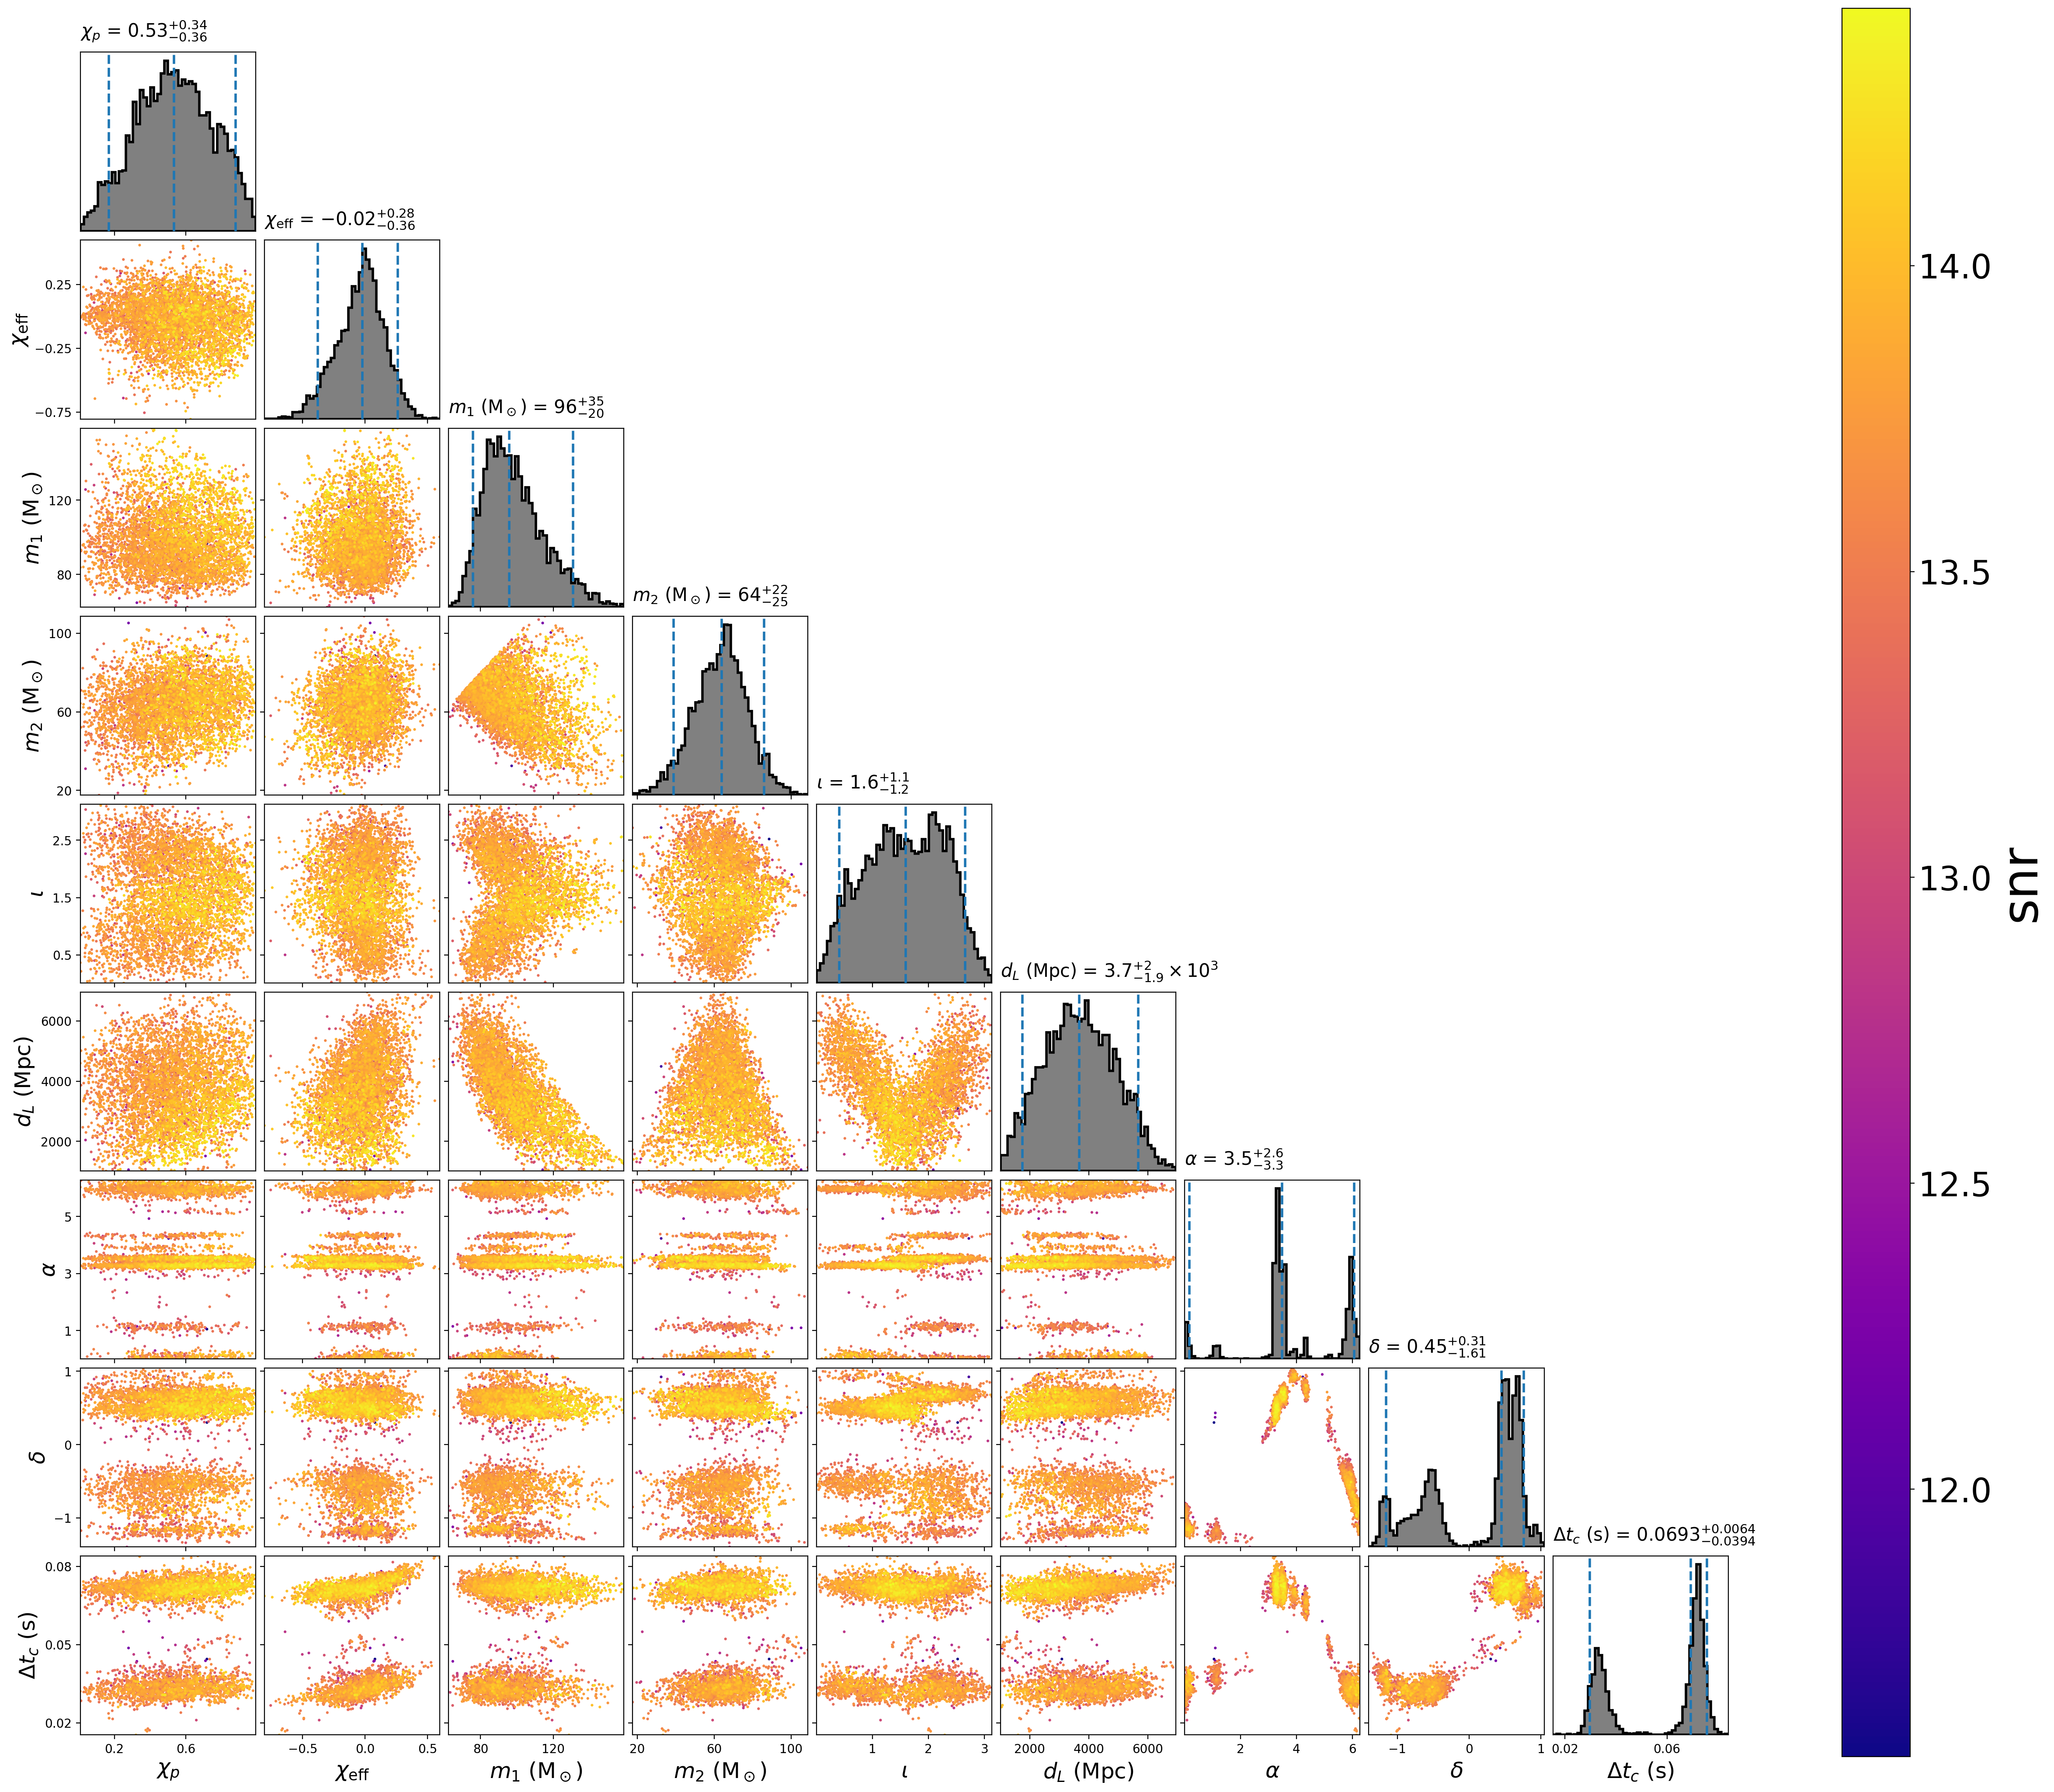

In [ ]:
Image('posterior.png', height=800)

In [ ]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior-chi.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters  'chi_p_from_spherical(mass1, mass2, spin1_a, spin1_azimuthal, spin1_polar, spin2_a, spin2_azimuthal, spin2_polar):chi_p' 'chi_eff_from_spherical(mass1, mass2, spin1_a, spin1_polar, spin2_a, spin2_polar):chi_eff'  

2021-01-27 09:51:49,843 Reading input file inference-masses.hdf
2021-01-27 09:51:49,845 Loading samples
2021-01-27 09:51:49,882 Loaded 5250 samples
2021-01-27 09:51:49,889 Plotting
2021-01-27 09:51:53,763 Done


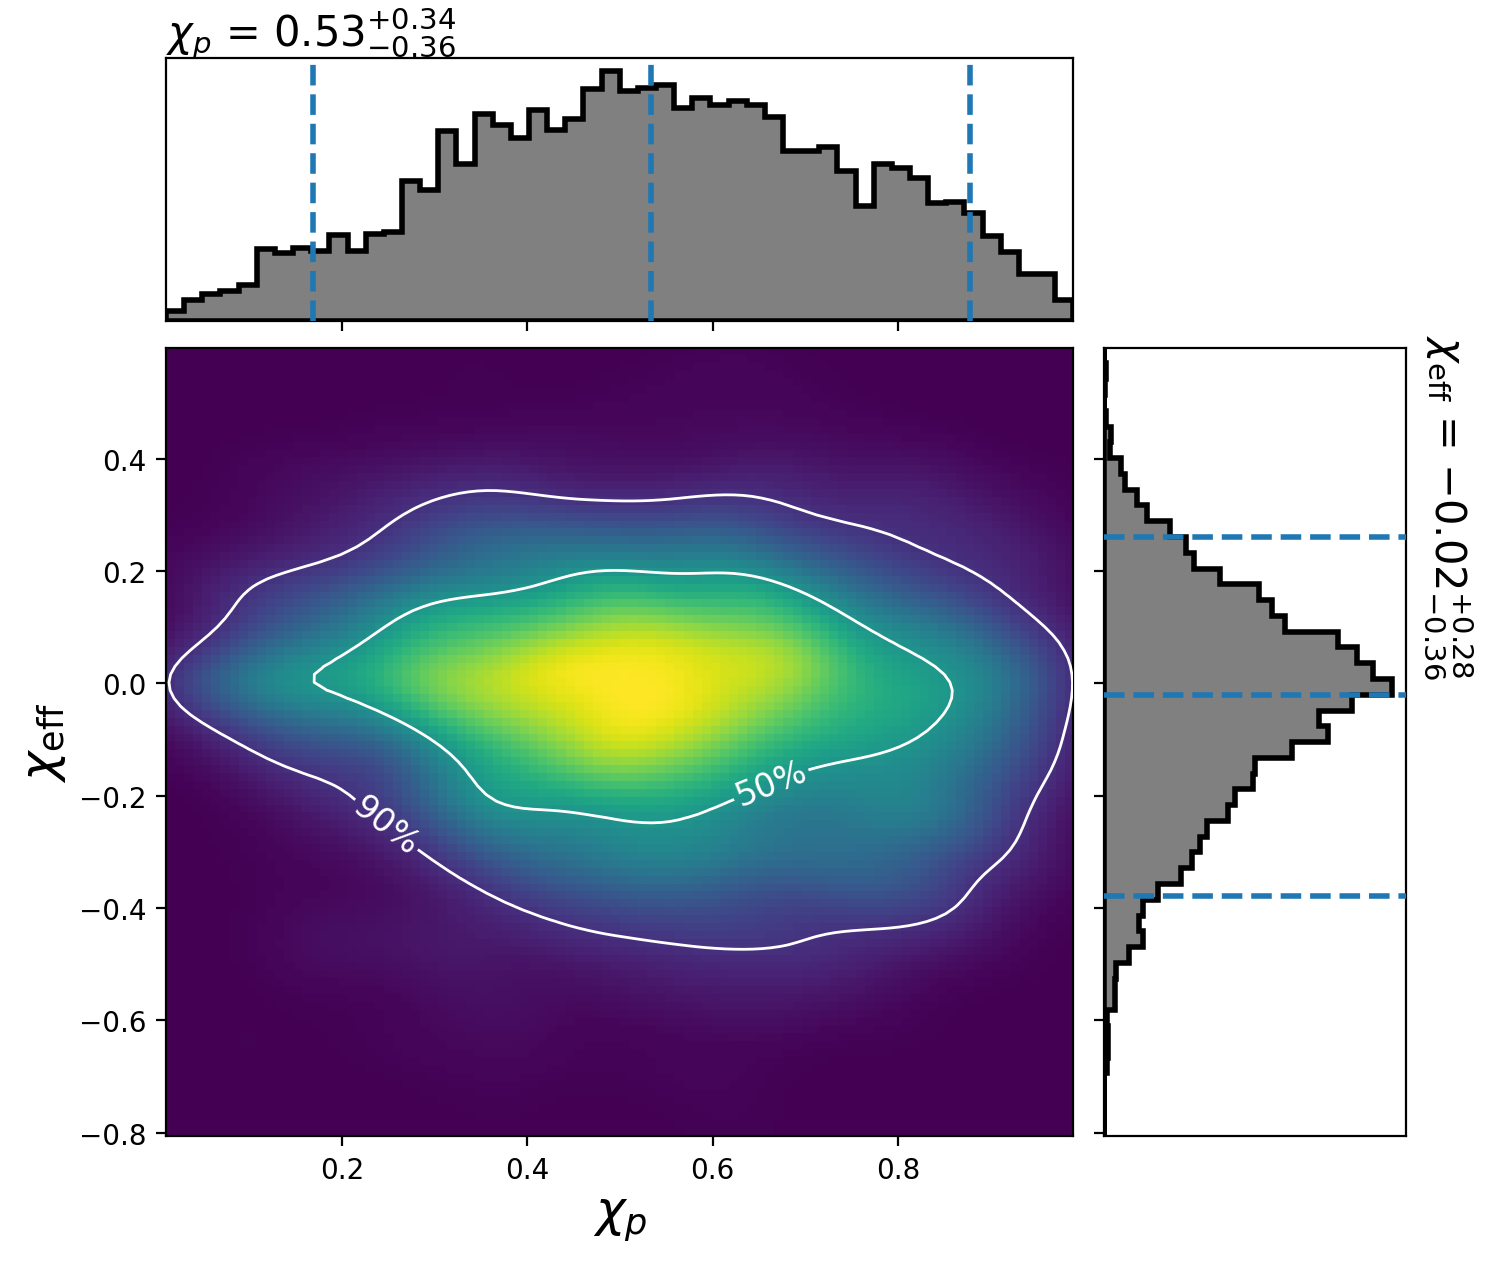

In [ ]:
Image('posterior-chi.png', height=800)

In [ ]:
!pycbc_inference_table_summary \
    --input-file inference-masses.hdf \
    --output-file posterior_summary.html \
    --verbose

2021-01-27 09:52:36,395 Reading input file inference-masses.hdf
2021-01-27 09:52:36,397 Loading samples
2021-01-27 09:52:36,466 Loaded 5250 samples


In [ ]:
from IPython.display import HTML
HTML('posterior_summary.html')

In [ ]:
!{sys.executable} -m pip install ligo.skymap --no-cache-dir

     |████████████████████████████████| 19.3MB 60.5MB/s 
     |████████████████████████████████| 2.3MB 53.4MB/s 
     |████████████████████████████████| 2.3MB 54.4MB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
     |████████████████████████████████| 1.3MB 38.7MB/s 
     |████████████████████████████████| 15.8MB 49.1MB/s 
     |████████████████████████████████| 276kB 44.9MB/s 
  Created wheel for python-ligo-lw: filename=python_ligo_lw-1.7.0-cp36-cp36m-linux_x86_64.whl size=178582 sha256=e0673193960bff5d70fb8a661409edb8b72373fb0e11f4d942a5b657cefde0cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pp63xmu/wheels/7f/c8/25/ed8f6ce595f466dbf583c27dc78b201fcf4dfeaf0a13d9c426
  Created wheel for ptemcee: filename=ptemcee-1.0.0-cp36-none-any.whl size=18551 sha256=e7beb9c1a25e34b49377fd2d56d03fee9605fd31a946b6363e40b96ac4ed38c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7pp63xmu/wheels/da/89/43/424c452a5548876bab54b4c57532a19e6557b48f9651e8c79c
  Created wheel for ast

In [ ]:
!pycbc_inference_create_fits \
    --tc '{m.time} + delta_tc' \
    --input-file inference-masses.hdf \
    --output-file inference-masses.fits

|===========================================|  26k/ 26k (100.00%)         0s
2021-01-27 09:54:01,386 INFO reading samples
2021-01-27 09:54:01,662 INFO clustering ...
100% 200/200 [1:16:34<00:00, 22.97s/it]
2021-01-27 11:10:36,530 INFO clustering ...
100% 200/200 [39:13<00:00, 11.77s/it]
2021-01-27 11:49:49,890 INFO pickling
2021-01-27 11:49:49,897 INFO making skymap
adaptive refinement round 1 of 7 ...
adaptive refinement round 2 of 7 ...
adaptive refinement round 3 of 7 ...
adaptive refinement round 4 of 7 ...
adaptive refinement round 5 of 7 ...
adaptive refinement round 6 of 7 ...
adaptive refinement round 7 of 7 ...
evaluating distance layers ...
100% 16896/16896 [01:35<00:00, 176.16it/s]


In [ ]:
!pycbc_inference_plot_skymap \
    --input-file inference-masses.fits \
    --output-file posterior-skymap.png

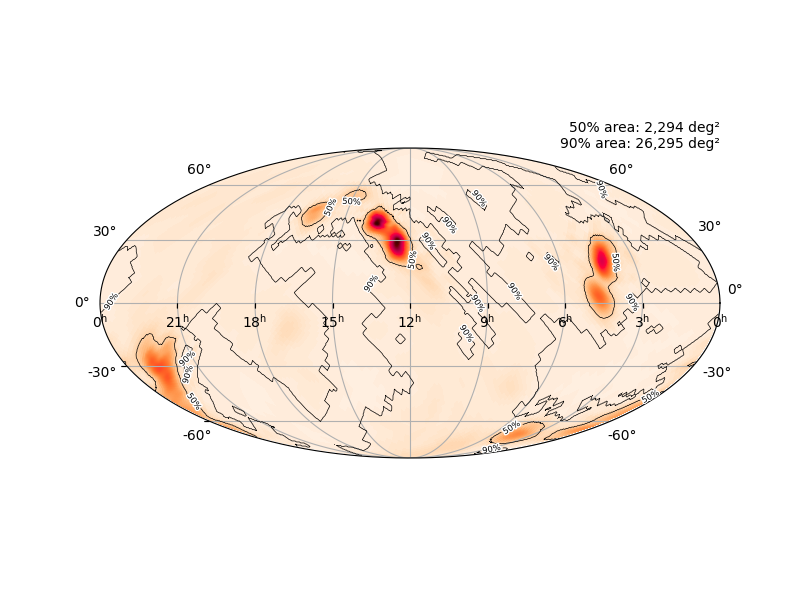

In [ ]:
Image('posterior-skymap.png', height=480)